### Lesson 2

#### Step 1. Gather images
-  Import libraries

In [ ]:
from duckduckgo_search import *
from fastcore.all import *
from fastdownload import download_url
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *

import warnings
warnings.filterwarnings("ignore")

- Check the function and the maximum number of downloaing images

In [ ]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [ ]:
results = search_images_ddg("swine")
len(results)

200

- Demo the search results

In [ ]:
results[0]

'https://ichef.bbci.co.uk/images/ic/1200x675/p01ggpwn.jpg'

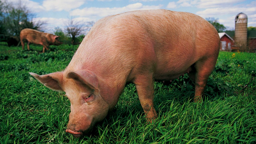

In [ ]:
# Save the image
path = 'asset-lesson-2'
dest = path+'/lesson-2-example-swine.jpg'
download_url(results[0], dest, show_progress=False)

# Show the image
im = Image.open(dest)
display(im.to_thumb(256,256))
Path(dest).unlink()

- Search and save images

In [ ]:
pig_types = "boar", "peppa pig"
path = Path(path)

for p in pig_types:
    dest = (path/p)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(p))
    resize_images(path/p, max_size=400, dest=path/p)

- Remove broken images

In [ ]:
fns = get_image_files(path)
fns

(#808) [Path('asset-lesson-2/swine/f6127288-47b1-45c0-a940-cdf00053d547.jpg'),Path('asset-lesson-2/swine/c336e486-fc46-4f7b-8360-3c364a8d601b.png'),Path('asset-lesson-2/swine/56ee69a6-507a-41a1-8725-641e2f5cd559.jpeg'),Path('asset-lesson-2/swine/593f5a52-027d-4d31-b2b0-81003a0e93f5.jpg'),Path('asset-lesson-2/swine/7ddd436f-1f3a-43ee-a4fb-f5fbe59dcbe4.jpg'),Path('asset-lesson-2/swine/09d5c5eb-3c4a-43c2-bf42-e448c2d98f07.jpg'),Path('asset-lesson-2/swine/a30b9155-7d27-479d-b938-948c0e148e54.jpeg'),Path('asset-lesson-2/swine/fdb93a23-fd18-47d1-bc81-00b973d7a25b.jpg'),Path('asset-lesson-2/swine/a132acdd-c1f3-4259-8a36-fcc3f318a129.jpg'),Path('asset-lesson-2/swine/35ffe9a3-dc5a-4324-a7cb-05c1df9a332e.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#18) [Path('asset-lesson-2/swine/77ca3727-93f9-4bf9-b2ef-c1e3abc14e86.jpg'),Path('asset-lesson-2/boar/5e7a1560-ba6b-4964-9c2d-6662e6b3f7b9.jpg'),Path('asset-lesson-2/boar/8236c886-22b5-42f0-93da-c150343f6675.jpg'),Path('asset-lesson-2/boar/23f39025-38c6-4896-aaa3-9acc99b6233a.jpg'),Path('asset-lesson-2/boar/ef3d7f20-bc6b-4d38-8d88-82cc13b858cb.jpg'),Path('asset-lesson-2/boar/fd70c7f3-ff90-4e85-9e4e-38ceb2bdeb8e.jpg'),Path('asset-lesson-2/boar/6d6142a8-710c-4423-b905-11e50bc63248.jpg'),Path('asset-lesson-2/boar/924b1c0d-a4c9-4823-9f24-ee30dd53d507.jpg'),Path('asset-lesson-2/peppa pig/5b03de1b-54d5-4b21-8c9f-41a5f4fb79c4.jpg'),Path('asset-lesson-2/peppa pig/ec6bf4f8-fb22-4338-a240-65c5dff4179f.jpg')...]

In [ ]:
failed.map(Path.unlink)

(#18) [None,None,None,None,None,None,None,None,None,None...]

#### Step 2. Transformation and Augmentation
- Define DataBlock and DataLoader
- Transformation:
  - Crop to Size

In [ ]:
pigs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = pigs.dataloaders(path)

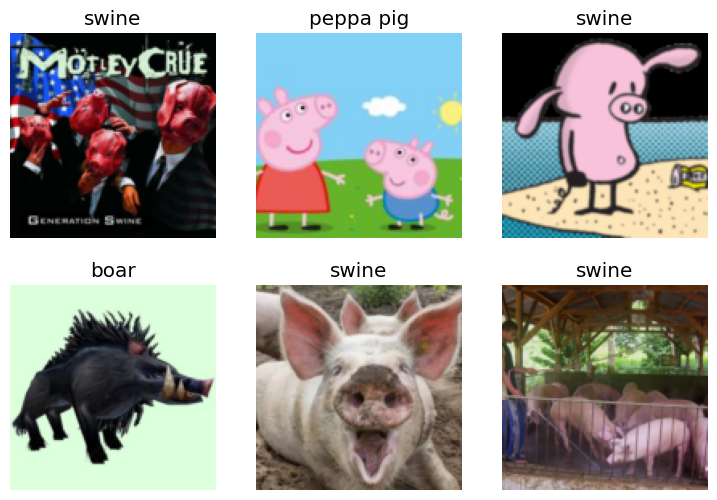

In [ ]:
dls.valid.show_batch(max_n=6, nrows=2)

- Transformation:
  - Squish to Size

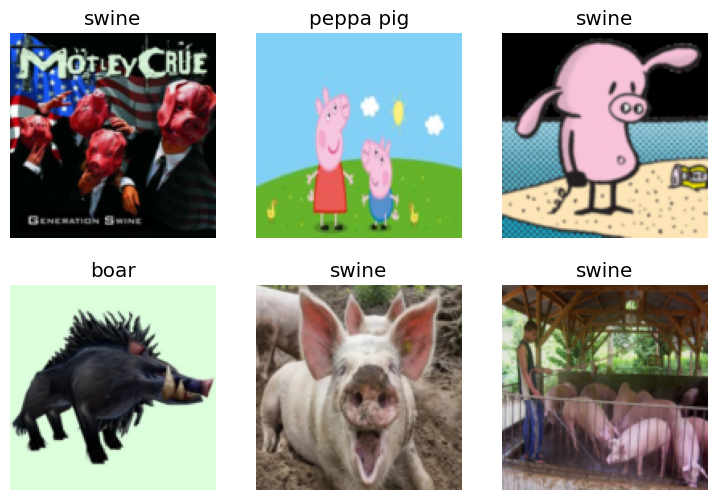

In [ ]:
pigs = pigs.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = pigs.dataloaders(path)
dls.valid.show_batch(max_n=6, nrows=2)

- Transformation:
  - RandomResizedCrop

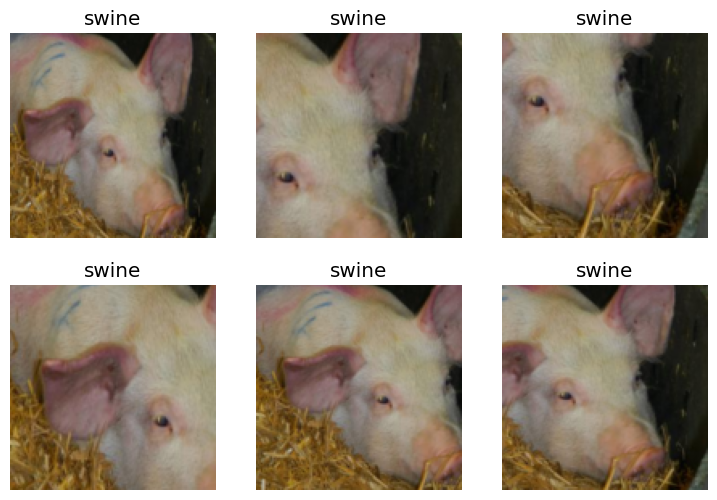

In [ ]:
pigs = pigs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pigs.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=2, unique=True)

- Augmentation

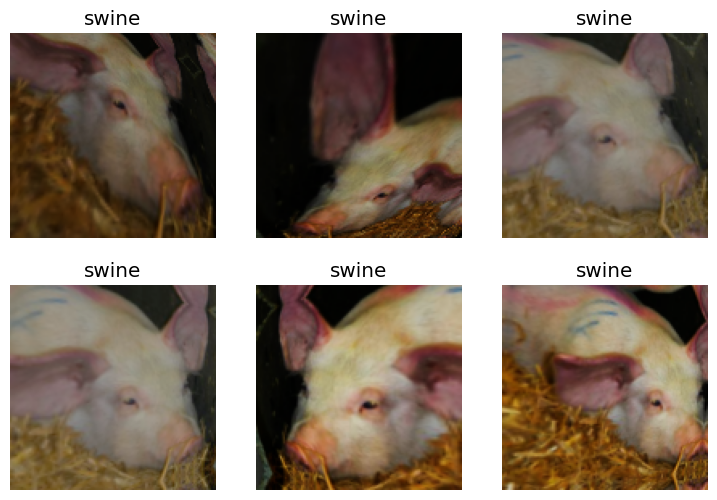

In [ ]:
pigs = pigs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pigs.dataloaders(path)
dls.train.show_batch(max_n=6, nrows=2, unique=True)

#### Step 3. Train the model

In [ ]:
pigs = pigs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pigs.dataloaders(path)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

- Performance

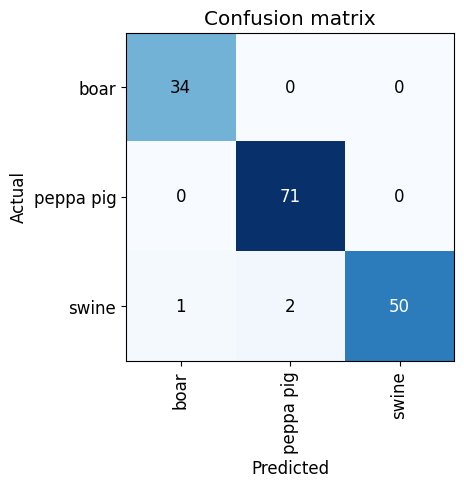

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

- Top loss:
  1. Wrong with high confidence
  2. Right with low confidence

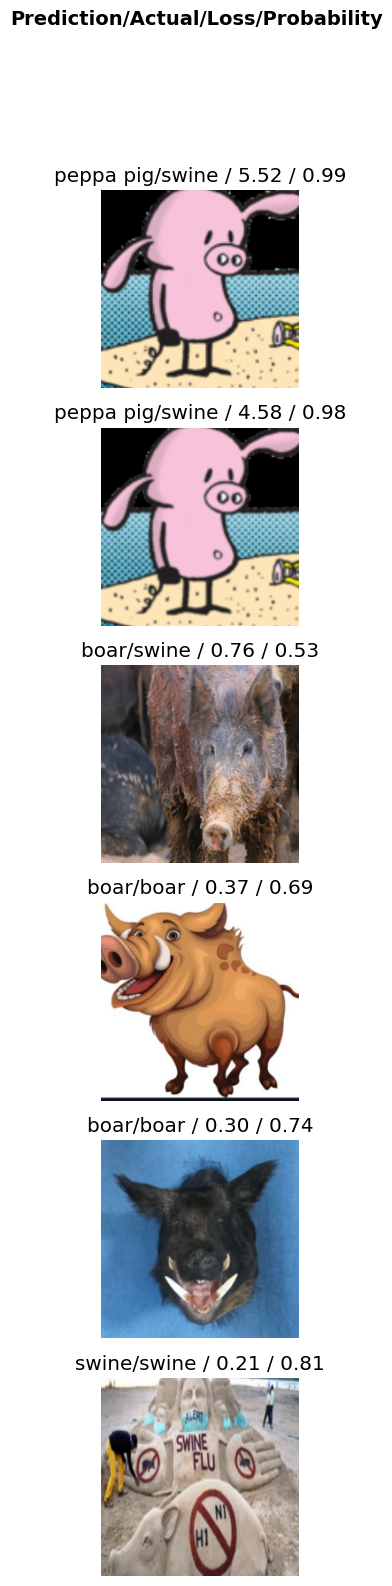

In [ ]:
interp.plot_top_losses(6, nrows=6)

#### Step 4. Clean the iamge data

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)